In [ ]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import CustomObjectScope
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score

from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation
from tensorflow.keras.layers import MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

#Dataloader

In [ ]:
H = 256
W = 256

def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)
create_dir("files")

In [ ]:
def load_dataset(path, split=0.2):
    images = sorted(glob(os.path.join(path, "images", "*.png")))
    masks = sorted(glob(os.path.join(path, "masks", "*.png")))

    split_size = int(len(images) * split)

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

In [ ]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (W, H))
    x = x / 255.0
    x = x.astype(np.float32)
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## (h, w)
    x = cv2.resize(x, (W, H))   ## (h, w)
    x = x / 255.0               ## (h, w)
    x = x.astype(np.float32)    ## (h, w)
    x = np.expand_dims(x, axis=-1)## (h, w, 1)
    return x

In [ ]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([H, W, 3])
    y.set_shape([H, W, 1])
    return x, y

def tf_dataset(X, Y, batch=2):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

In [ ]:
batch_size = 16
lr = 1e-4
num_epochs = 100
model_path = os.path.join("files", "model.h5")
csv_path = os.path.join("files", "log.csv")
dataset_path="/content/drive/MyDrive/BrainTumorDataset"

In [ ]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)

print(f"Train: ({len(train_x)},{len(train_y)})")
print(f"Valid: ({len(valid_x)},{len(valid_x)})")
print(f"Test: ({len(test_x)},{len(test_x)})")

Train: (1840,1840)
Valid: (612,612)
Test: (612,612)


In [ ]:
train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

#LinkNet

In [ ]:
def encoder_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    p = MaxPool2D((2, 2))(x)
    return x, p

In [ ]:
def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, 2, strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [ ]:
def linknet(input_shape):
    inputs = Input(input_shape)

    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p4 = encoder_block(p3, 256)


    d1 = decoder_block(p4, s4, 256)
    d2 = decoder_block(d1, s3, 128)
    d3 = decoder_block(d2, s2, 64)
    d4 = decoder_block(d3, s1, 32)

    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    model = Model(inputs, outputs, name="LINKNET")
    return model

model = linknet((256,256,3))
model.summary()

Model: "LINKNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                           

In [ ]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

In [ ]:
model = linknet((H, W, 3))
model.compile(loss=dice_loss, optimizer=Adam(lr), metrics=[dice_coef,'accuracy'])

In [ ]:
callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
        CSVLogger(csv_path),
        EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False),
    ]

In [ ]:
model.fit(
        train_dataset,
        epochs=num_epochs,
        validation_data=valid_dataset,
        callbacks=callbacks,
        verbose=0,
    )


Epoch 1: val_loss improved from inf to 0.96450, saving model to files/model.h5

Epoch 2: val_loss improved from 0.96450 to 0.96409, saving model to files/model.h5

Epoch 3: val_loss improved from 0.96409 to 0.95431, saving model to files/model.h5

Epoch 4: val_loss improved from 0.95431 to 0.90587, saving model to files/model.h5

Epoch 5: val_loss improved from 0.90587 to 0.86750, saving model to files/model.h5

Epoch 6: val_loss improved from 0.86750 to 0.86021, saving model to files/model.h5

Epoch 7: val_loss improved from 0.86021 to 0.71743, saving model to files/model.h5

Epoch 8: val_loss did not improve from 0.71743

Epoch 9: val_loss improved from 0.71743 to 0.60179, saving model to files/model.h5

Epoch 10: val_loss improved from 0.60179 to 0.59480, saving model to files/model.h5

Epoch 11: val_loss improved from 0.59480 to 0.50422, saving model to files/model.h5

Epoch 12: val_loss improved from 0.50422 to 0.47877, saving model to files/model.h5

Epoch 13: val_loss improved 

KeyboardInterrupt: ignored

In [ ]:
model.load_

#Visualize

In [ ]:
import pandas as pd
metrics = pd.read_csv("/content/files/log.csv")
metrics.head(5)

,epoch,accuracy,dice_coef,loss,lr,val_accuracy,val_dice_coef,val_loss
0,0,0.730168,0.079083,0.920917,0.0001,0.982255,0.035417,0.964502
1,1,0.936493,0.120976,0.879024,0.0001,0.974710,0.035844,0.964088
2,2,0.957387,0.150537,0.849464,0.0001,0.767209,0.045845,0.954306
3,3,0.969455,0.182838,0.817162,0.0001,0.858644,0.094428,0.905872
4,4,0.975656,0.218557,0.781443,0.0001,0.889246,0.132950,0.867503


<Axes: >

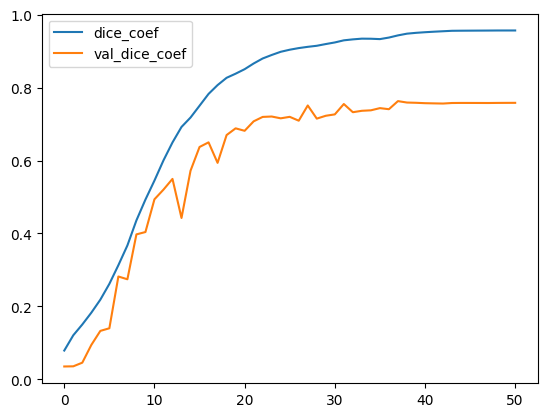

In [ ]:
metrics[['dice_coef','val_dice_coef']].plot()


<Axes: >

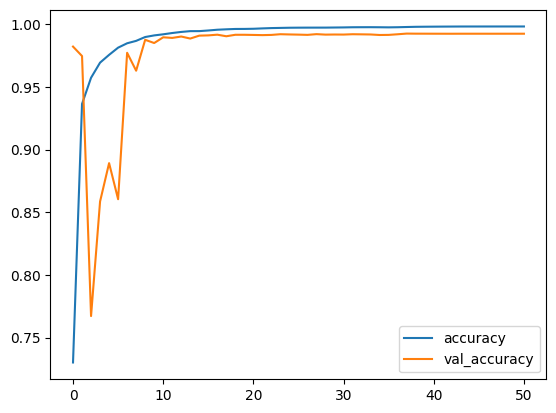

In [ ]:
metrics[['accuracy','val_accuracy']].plot()


In [ ]:
path = "/content/drive/MyDrive/BrainTumorDataset/images/100.png"
image = cv2.imread(path,cv2.IMREAD_COLOR)
image = cv2.resize(image, (W, H))
x = image/255.0
x = np.expand_dims(x, axis=0)
y_pred = model.predict(x, verbose=0)[0]
y_pred = np.squeeze(y_pred, axis=-1)

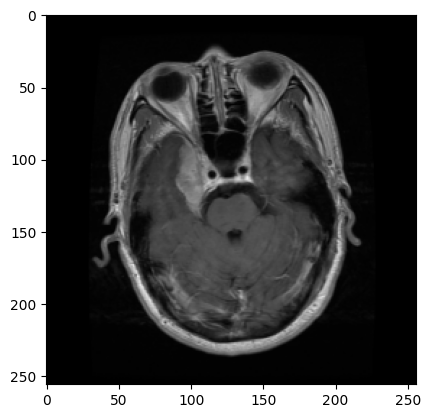

In [ ]:
path = "/content/drive/MyDrive/BrainTumorDataset/masks/100.png"
image2 = cv2.imread(path,cv2.IMREAD_COLOR)
plt.imshow(image)

(-0.5, 511.5, 511.5, -0.5)

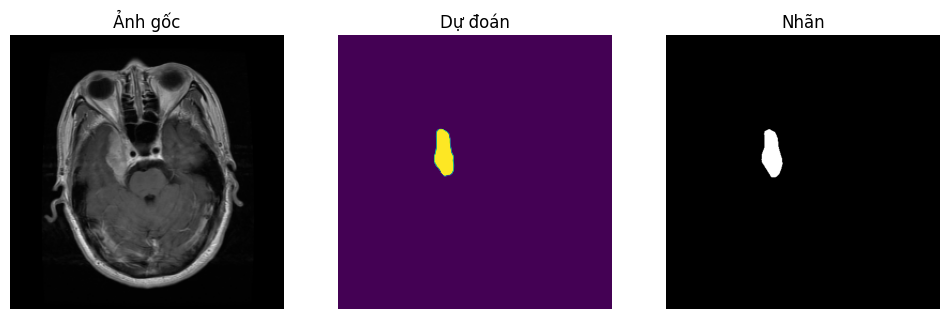

In [ ]:
plt.figure(figsize=(12, 4))


# Hiển thị ảnh gốc
plt.subplot(131)
plt.imshow(image)
plt.title("Ảnh gốc")
plt.axis("off")

# Hiển thị ảnh đã xử lí
plt.subplot(132)
plt.imshow(y_pred)
plt.title("Dự đoán")
plt.axis("off")

# Hiển thị ảnh đã xử lí
plt.subplot(133)
plt.imshow(image2)
plt.title("Nhãn")
plt.axis("off")
